# INFO 3350/6350

## Lecture 06: Clustering

## To do

* Week 5 reading
    * Wednesday: Read articles by Allison et al. and by Mauch et al.
        * Response due by 4:00pm Tuesday if assigned to you by NetID (H-P).

## Supervised and unsupervised learning

* "Clustering" is a type of *unsupervised* learning
* "Classification" (next week) is a type of *supervised* learning
* Both seek to assign a finite set of labels to input objects on the basis of features associated with those objects
* In *supervised* learning, you know the labels in advance
    * You supply a set of (correctly) labeled objects to the algorithm
    * The algorithm then "learns" which features are associated with which labels, so as to minimize classification errors
* In *unsupervised* learning, you don't know the labels (though you might know -- or at least have a sense about -- how *many* labels there should be)
    * You supply a feature matrix and a definition of what a "good" clustering should be
    * The algorithm then assigns labels to the input objects so as to best satisfy the supplied definition of "good" (typically, minimizing variance within clusters and maximizing difference between clusters)

## Why prefer one or the other?

* Unsupervised methods are often used early in a project, when you're looking for unknown stucture in your data
    * Unsupervised methods are your only option if you don't know what the appropriate set of labels might be for your data set
    * Also appropriate if you don't have (many) labeled instances
    * Unsupervised methods are typically "cheap" to set up, but costly to evaluate
* Supervised methods require you to know in advance the full set of appropriate labels for your data
    * Supervised methods often have high initial costs, but are easier to evaluate (because you already have a set of correctly labeled instances that you can use for validation).

## Cluster boundaries

[sketch the problem]

* Note that not all clusters have the same general shape
* Spherical blobs, separate linear blobs, areas of varying density, etc.
* There is no universally best way to draw decision boundaries

## *k*-means clustering

The algorithm:

1. Select *k* objects from the data set to serve as initial cluster centers ("centroids")
1. Assign each object in the data set to the nearest centroid. These are your initial clusters.
1. Calculate the mean location of the objects assigned to each cluster. These are your new centroids.
1. If the new centroids are sufficiently close to the previous centroids, you're done.
    1. If the new centroids are not sufficiently close to the old centroids, use the new centroids as the basis for a new clustering.
    1. Repeat labeling, centroid calculation, and difference comparison until centroids are stable (enough).

## Other clustering methods

* Ward (hierarchical), agglomerative
* Density-based (DBSCAN, OPTICS)
* Graph distance (affinity propagation, spectral)
* ...

## An artificial example

### *k*-Means

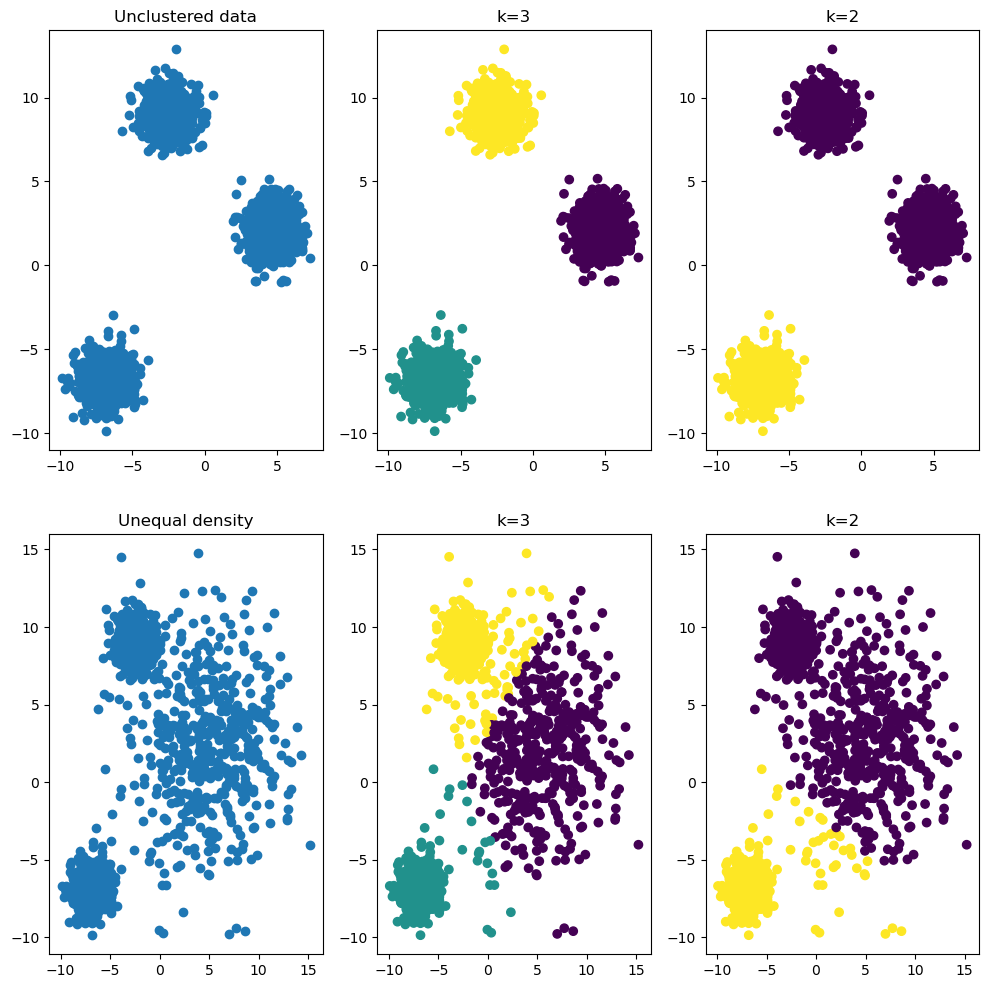

In [1]:
# k-Means on articial data
# Adapted from sklearn examples

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

# make artificial data (demo only, not part of the real-world process)
n_samples = 1500
random_state = 42
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Unlabeled data
plt.subplot(231)
plt.scatter(X[:, 0], X[:, 1])
plt.title("Unclustered data")

# Correct number of clusters
#  Note we are doing three steps (instantiate, fit, predict)
#  in one line of code here
y_pred = KMeans(n_clusters=3, random_state=random_state, n_init='auto').fit_predict(X)

plt.subplot(232)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("k=3")


# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state, n_init='auto').fit_predict(X)

plt.subplot(233)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("k=2")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 4.0, 1.0],
                                random_state=random_state)

plt.subplot(234)
plt.scatter(X_varied[:, 0], X_varied[:, 1])
plt.title("Unequal density")

y_pred = KMeans(n_clusters=3, random_state=random_state, n_init='auto').fit_predict(X_varied)

plt.subplot(235)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("k=3")

y_pred = KMeans(n_clusters=2, random_state=random_state, n_init='auto').fit_predict(X_varied)

plt.subplot(236)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("k=2")


plt.show()

### OPTICS

Another method implemented by `scikit-learn`, so easy to plug in. See the [package documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) and the [user guide](https://scikit-learn.org/stable/modules/clustering.html#optics). 

OPTICS is a density-based algorthim similar to DBSCAN or (especially) to HDBSCAN (since the later, like OPTICS, allows variable cut points by calculating an ordered reachability graph between points). The advantage of OPTICS and HDBSCAN over base DBSCAN is the ability to identify clusters of different densities. But this also means that parameters like `xi` (OPTICS) and `min_samples` (HDBSCAN), as well as `eps` in original DBSCAN are really important. The defaults are sane for normalized, scaled, normally distributed data, but they might not be right for your data.

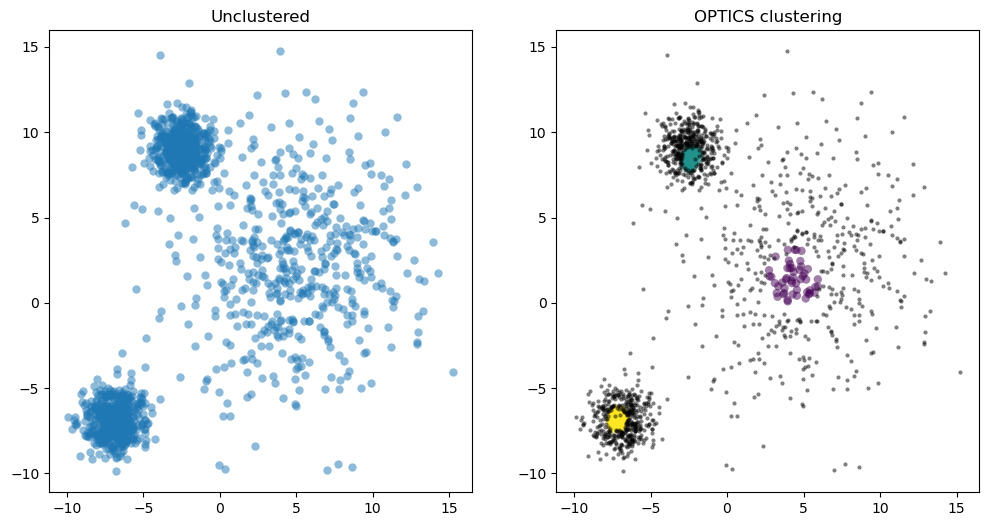

In [6]:
from sklearn.cluster import OPTICS

# perform clustering
# xi defines the cutoff for steepness of the reachability curve
optics_clusterer = OPTICS(min_samples=50, xi=0.01, min_cluster_size=0.01)
optics_clusterer.fit(X_varied)
y_optics = optics_clusterer.labels_

# plot result
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_varied[:, 0], X_varied[:, 1], alpha=0.5, linewidths=0)
plt.title("Unclustered")

plt.subplot(122)

plt.scatter(X_varied[y_optics >=0, 0], X_varied[y_optics >=0, 1], c=y_optics[y_optics>=0], alpha=0.5, linewidths=0)
plt.scatter(X_varied[y_optics <0, 0], X_varied[y_optics <0, 1], c='k', marker='.', alpha=0.5, linewidths=0)
plt.title("OPTICS clustering")

plt.show()

## Demo: Historical cookbooks

We have a dataset of almost 50,000 recipes from 70+ American cookbooks (sourced from the [Feeding America](https://d.lib.msu.edu/fa) project at Michigan State, processed via [Humanities Data Analysis](https://www.humanitiesdataanalysis.org/introduction-cook-books/notebook.html#an-exploratory-data-analysis-of-the-united-states-culinary-history)). Let's see if we can discover some structure in this dataset.

### Data

In [7]:
# read the data
import os
import pandas as pd
cook = pd.read_csv(os.path.join('..', 'data', 'cookbooks', 'feeding-america.csv'))
cook.head()

,book_id,date,ethnicgroup,recipe_class,region,ingredients
0,fofb.xml,1922,mexican,soups,ethnic,chicken;green pepper;rice;salt;water
1,fofb.xml,1922,mexican,meatfishgame,ethnic,chicken;rice
2,fofb.xml,1922,mexican,soups,ethnic,allspice;milk
3,fofb.xml,1922,mexican,fruitvegbeans,ethnic,breadcrumb;cheese;green pepper;pepper;salt;sar...
4,fofb.xml,1922,mexican,eggscheesedairy,ethnic,butter;egg;green pepper;onion;parsley;pepper;s...


In [8]:
# how many recipes of each type?
cook.recipe_class.value_counts()

recipe_class
breadsweets        14630
meatfishgame       11477
fruitvegbeans       7085
accompaniments      5495
eggscheesedairy     4150
soups               2631
beverages           2031
medhealth            533
Name: count, dtype: int64

In [ ]:
# subset the data to bread recipes and meat recipes
breadmeat = cook.loc[cook.recipe_class.isin(["breadsweets", "meatfishgame"])]

In [ ]:
# vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    use_idf=False,
    tokenizer=lambda x: x.split(';'), # use existing tokenization by ingredient
    token_pattern=None,
    min_df=100 # limit to common ingedients
)
features = vectorizer.fit_transform(breadmeat['ingredients'])
print("Feature matrix shape:", features.shape)

In [ ]:
# glance at some feature names
vectorizer.get_feature_names_out()[:20]

### Visualization

In [ ]:
# visualize the data via PCA/SVD
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
import seaborn as sns

X_reduced = TruncatedSVD().fit_transform(features)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=breadmeat['recipe_class'], alpha=0.02)
plt.show()

FYI, these "wedge-shaped" PCA plots are common with text data. Waving hands a bit, the edges of the wedge correspond to the edges of the upper right quadrant in the original data (that is, our values for every feature are strictly non-negative); the density of data near the point of the wedge indicates that there are lots of zero values in our data (which is typical of text data).

In [ ]:
# vis with UMAP
from umap import UMAP

X_umap = UMAP().fit_transform(features)
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=breadmeat['recipe_class'], alpha=0.02)
plt.show()

### KMeans

In [ ]:
# cluster with KMeans
y_pred = KMeans(n_clusters=2, random_state=random_state, n_init='auto').fit_predict(features)

In [ ]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, hue_order=[1,0], alpha=0.02)
plt.show()

#### Results

Examine cases where our cluster label doesn't match the existing label. This is fine as a pedagogical exercise, but remember that you would only really use unsupervised methods when you **don't** know the "correct" labels for your data. For that reason. we're not going to spend much time considering accuracy here. You **do** need to evaluate your clustering results, but you can't typically do it via direct accuracy metrics.

In [ ]:
# "errors"
errors = breadmeat.loc[
    ((breadmeat['recipe_class']=='meatfishgame') & (y_pred==0)) |
    ((breadmeat['recipe_class']=='breadsweets')  & (y_pred==1))
]
print("Label differences:", len(errors))
errors.sample(10)

### [Agglomerative clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

This one is slow ...

In [ ]:
%%time
from sklearn.cluster import AgglomerativeClustering
clusterer = AgglomerativeClustering()
y_pred = clusterer.fit_predict(features.toarray())

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, hue_order=[1,0], alpha=0.02)
plt.show()

In [ ]:
# "errors"
errors = breadmeat.loc[
    ((breadmeat['recipe_class']=='meatfishgame') & (y_pred==0)) |
    ((breadmeat['recipe_class']=='breadsweets')  & (y_pred==1))
]
print("Label differences:", len(errors))
errors.sample(10)

### [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

In [ ]:
from sklearn.cluster import DBSCAN
clusterer = DBSCAN(min_samples=50, eps=0.75)
y_pred = clusterer.fit_predict(features.toarray())

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, alpha=0.02)
plt.show()